# Introduction

This projects aims to clustering cuatomers of a online retail shop

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

We will be using the online retail trasnational dataset to build a clustering and choose the best set of customers which the company should target.


# Reading and Understanding the data

In this section, we will understand the data, will explore the size, types of attributes, and the status of null variables.



In [372]:
import pandas as pd,seaborn as sns,matplotlib.pyplot as plt,numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import DBSCAN

In [373]:
data=pd.read_csv('OnlineRetail.csv',sep=',',encoding="ISO-8859-1", header=0)

In [374]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [375]:
#data.shape

Above is a short glimpse of the data. This is a large dataset with 541909 rows and 8 columns. The table shows statistical details about the numerical columns of the data.



In [376]:
print(data.describe().to_markdown())

|       |     Quantity |    UnitPrice |   CustomerID |
|:------|-------------:|-------------:|-------------:|
| count | 541909       | 541909       |     406829   |
| mean  |      9.55225 |      4.61111 |      15287.7 |
| std   |    218.081   |     96.7599  |       1713.6 |
| min   | -80995       | -11062.1     |      12346   |
| 25%   |      1       |      1.25    |      13953   |
| 50%   |      3       |      2.08    |      15152   |
| 75%   |     10       |      4.13    |      16791   |
| max   |  80995       |  38970       |      18287   |


In [377]:
print(data.dtypes.to_markdown())

|             | 0       |
|:------------|:--------|
| InvoiceNo   | object  |
| StockCode   | object  |
| Description | object  |
| Quantity    | int64   |
| InvoiceDate | object  |
| UnitPrice   | float64 |
| CustomerID  | float64 |
| Country     | object  |


In [378]:
null = 100*round(data.isnull().sum()/data.shape[0],2)

In [379]:
print(null.to_markdown())

|             |   0 |
|:------------|----:|
| InvoiceNo   |   0 |
| StockCode   |   0 |
| Description |   0 |
| Quantity    |   0 |
| InvoiceDate |   0 |
| UnitPrice   |   0 |
| CustomerID  |  25 |
| Country     |   0 |


In [380]:
#data.CustomerID.isnull().sum()

The column 'CustomerID' contains null values, the null values co. We have to clean the null rows.

In [381]:
data=data.dropna()

In [382]:
#data.shape

Dropped the null values and the rows of the data reduced to 406829.

In [383]:
data['CustomerID'] = data['CustomerID'].astype(str)

In [384]:
#data['CustomerID'].dtypes


The type of the CustomerID is given as a numerical object, for the ease of analysis, changed the type of column to String.

# Exploratory Data Analysis

In this section, we will do a detailed analysis of the data and prepares the data for the modeling.

For the Analysis of the customer, we use three information from Customers, those are:

1. Recency(R)  : Number of days since last purchase
2. Frequency(F): Number of transactions.
3. Monetary(M) : Total amount of transactions (revenue contributed)

To calculate the total amount spent by the Customer, multiplied the Quantity with UnitPrice. Then grouped the data by CustomerId and summed the Amount. First few rows of the Amount of customers is given by:

In [385]:
data['Amount'] = data['Quantity'] * data['UnitPrice']
Amount=data.groupby('CustomerID')['Amount'].sum()
Amount=Amount.reset_index()
print(Amount.head().to_markdown())

|    |   CustomerID |   Amount |
|---:|-------------:|---------:|
|  0 |        12346 |     0    |
|  1 |        12347 |  4310    |
|  2 |        12348 |  1797.24 |
|  3 |        12349 |  1757.55 |
|  4 |        12350 |   334.4  |


Calculated the frequency of purchase of a customer by countingthe InvoiceDate column for each customers and the table below shows the frequency.

In [386]:
Frequency = data.groupby('CustomerID')['InvoiceDate'].count()
Frequency=Frequency.reset_index()
Frequency.columns=['CustomerID','Frequrency']
print(Frequency.head().to_markdown())

|    |   CustomerID |   Frequrency |
|---:|-------------:|-------------:|
|  0 |        12346 |            2 |
|  1 |        12347 |          182 |
|  2 |        12348 |           31 |
|  3 |        12349 |           73 |
|  4 |        12350 |           17 |


In [387]:
Amou_freq = pd.merge(Amount, Frequency, on='CustomerID', how='inner')
print(Amou_freq.head().to_markdown())

|    |   CustomerID |   Amount |   Frequrency |
|---:|-------------:|---------:|-------------:|
|  0 |        12346 |     0    |            2 |
|  1 |        12347 |  4310    |          182 |
|  2 |        12348 |  1797.24 |           31 |
|  3 |        12349 |  1757.55 |           73 |
|  4 |        12350 |   334.4  |           17 |


To calculate the recency, that is the number of days since the last purchase, first calculated the maximum date of the Invoice date to know the last day of the transaction. Then estimated the difference in the days from the last purchase date for each entry and calculated the minimum difference in the days of each customer.

The table below shows recency of  few customers:

In [388]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [389]:
max_date=data['InvoiceDate'].max()

In [390]:
data['diff'] = max_date - data['InvoiceDate']

In [391]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [392]:
last_purchase = data.groupby('CustomerID')['diff'].min()
last_purchase=last_purchase.reset_index()
print(last_purchase.head().to_markdown())

|    |   CustomerID | diff              |
|---:|-------------:|:------------------|
|  0 |        12346 | 325 days 02:33:00 |
|  1 |        12347 | 1 days 20:58:00   |
|  2 |        12348 | 74 days 23:37:00  |
|  3 |        12349 | 18 days 02:59:00  |
|  4 |        12350 | 309 days 20:49:00 |


Then merged three data frame containing, amount, frequency, and recency of the customers.

In [393]:
grouped_df = pd.merge(Amou_freq, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
print(grouped_df.head().to_markdown())

|    |   CustomerID |   amount |   frequency | recency           |
|---:|-------------:|---------:|------------:|:------------------|
|  0 |        12346 |     0    |           2 | 325 days 02:33:00 |
|  1 |        12347 |  4310    |         182 | 1 days 20:58:00   |
|  2 |        12348 |  1797.24 |          31 | 74 days 23:37:00  |
|  3 |        12349 |  1757.55 |          73 | 18 days 02:59:00  |
|  4 |        12350 |   334.4  |          17 | 309 days 20:49:00 |


In [394]:
grouped_df['recency'] = grouped_df['recency'].dt.days


In [395]:
print(grouped_df.head().to_markdown())

|    |   CustomerID |   amount |   frequency |   recency |
|---:|-------------:|---------:|------------:|----------:|
|  0 |        12346 |     0    |           2 |       325 |
|  1 |        12347 |  4310    |         182 |         1 |
|  2 |        12348 |  1797.24 |          31 |        74 |
|  3 |        12349 |  1757.55 |          73 |        18 |
|  4 |        12350 |   334.4  |          17 |       309 |


Before applying different models on this data frame for clustering the customers, checked the outliers of the data using boxplots.
The boxplots displayed below shows there are outliers for all three columns, so we need to remove the outliers.

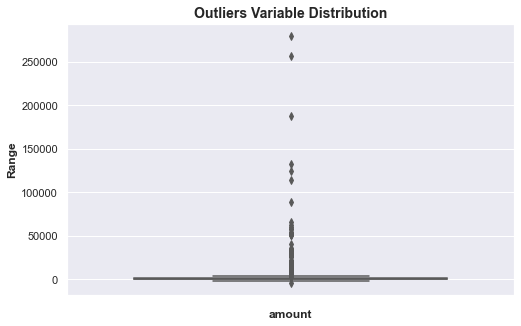

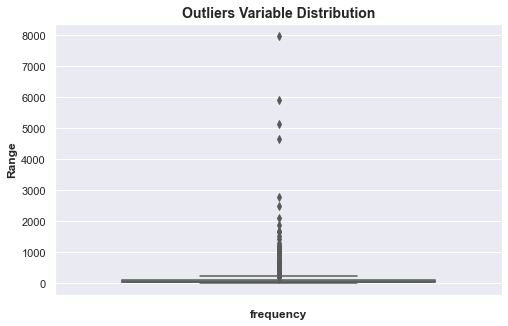

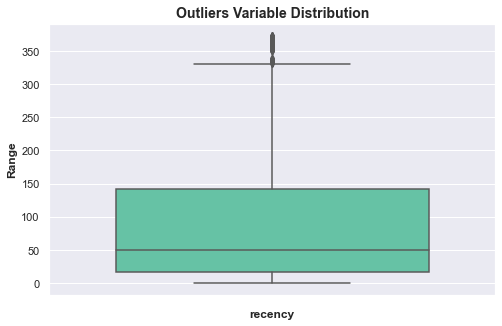

In [396]:
column = ['amount','frequency','recency']

for i,col in enumerate(column):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.figure(i)
    sns.boxplot(y=col,data = grouped_df, orient="h", palette="Set2" ,whis=1.5,saturation=1, width=0.7)

    plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel(col, fontweight = 'bold')

Sp removed the outliers which are not in between the interval of (Q1-1.5* IQR) and (Q3+1.5* IQR), where Q1, Q3 are lower and upper quartiles respectively and IQR is the Inter quartile range.

In [397]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

The boxplots after removing the outliers are given below:

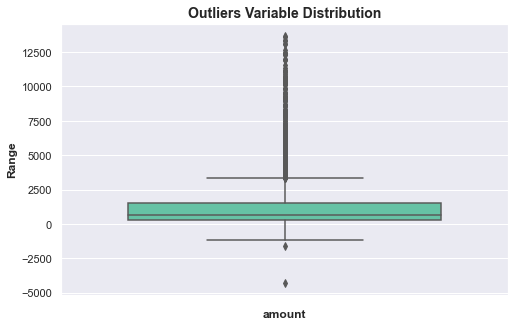

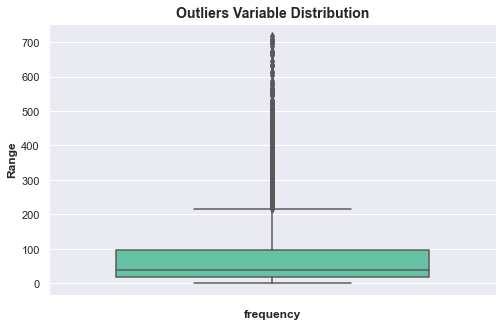

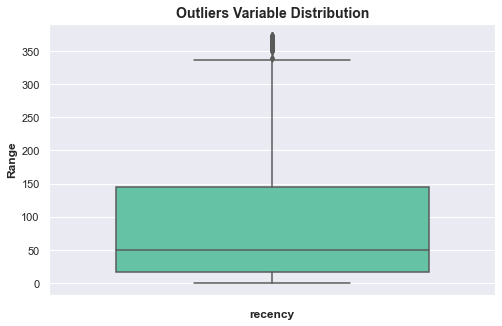

In [398]:
column = ['amount','frequency','recency']

for i,col in enumerate(column):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.figure(i)
    sns.boxplot(y=col,data = grouped_df, orient="h", palette="Set2" ,whis=1.5,saturation=1, width=0.7)

    plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel(col, fontweight = 'bold')

Plotted the histograms of the columns to look at the distribution of values.

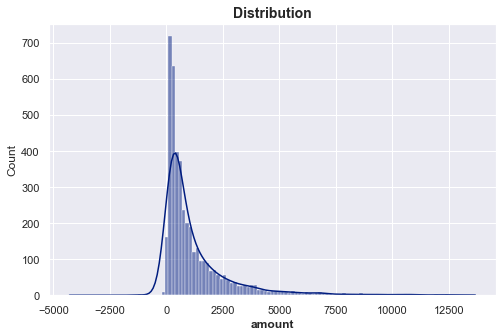

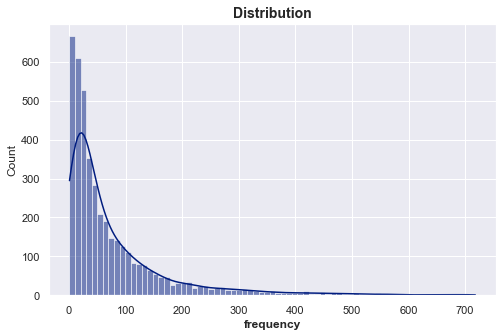

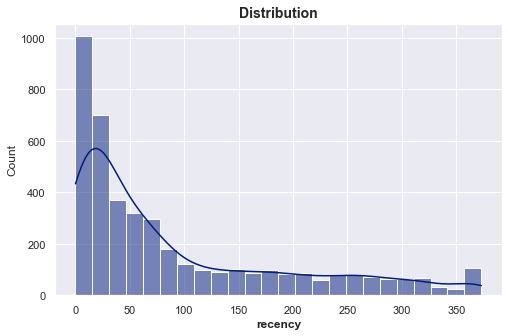

In [399]:
column = ['amount','frequency','recency']

for i,col in enumerate(column):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.figure(i)
    sns.histplot(x=col,data = grouped_df,kde=True)

    plt.title("Distribution", fontsize = 14, fontweight = 'bold')
   
    plt.xlabel(col, fontweight = 'bold')

## Rescaling the Attributes

To have a comparable scale, we rescale the variables using the Standardisation method, with mean 0 and sigma 1.



In [400]:
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df = scaler.fit_transform(rfm_df)
#rfm_df_scaled.shape

The dataframe after standard scaling is:

In [401]:
rfm_df = pd.DataFrame(rfm_df_scaled)
rfm_df.columns = ['amount', 'frequency', 'recency']
print(rfm_df.head().to_markdown())

|    |    amount |   frequency |   recency |
|---:|----------:|------------:|----------:|
|  0 | -0.723738 |  -0.752888  |  2.30161  |
|  1 |  1.73162  |   1.04247   | -0.906466 |
|  2 |  0.300128 |  -0.463636  | -0.183658 |
|  3 |  0.277517 |  -0.0447201 | -0.738141 |
|  4 | -0.533235 |  -0.603275  |  2.14319  |


Now we can apply different clustering methods to the dataset.

# Modeling

In this section we will apply, K-means Clustering, Hierarchial Clustering and DBSCAN to the data and develop clustors among customers of same feautures. 

## K-means Clustering

K means Clustering is one of the  simple and powerfull unsupervised clustering algorithms. In this algorithm, first
intializes some points(K) called means randomly and categorize each item to its closest mean. Then updates the mean’s coordinates, which are the averages of the items categorized in that mean so far. Repeats this process for given number of interation and at ath end we have k number of clusters.


To find out the optimum value for K, fit the data with cluster number range from 1 to 10 and used Elbow method to choose the best value for cluster number.

In [402]:
km_list = list()

for clust in range(1,10):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(rfm_df_scaled)
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

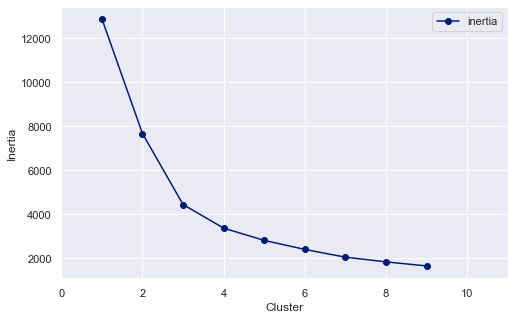

In [403]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,11,2))
ax.set_xlim(0,11)
ax.set(xlabel='Cluster', ylabel='Inertia');

In the Elbow plot above, the K value of 3 found out to be the optimum value, since the inertia of K values beyond 3 doesnt have sharp reduction. So we will fit the data with cluster number of 3.

In [406]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans=kmeans.fit(rfm_df_scaled)

In [407]:
rfm_df['ClusterID'] =  kmeans.labels_

In [408]:
rfm_df.head()

,amount,frequency,recency,ClusterID
0,-0.723738,-0.752888,2.301611,2
1,1.731617,1.042467,-0.906466,1
2,0.300128,-0.463636,-0.183658,0
3,0.277517,-0.044720,-0.738141,0
4,-0.533235,-0.603275,2.143188,2


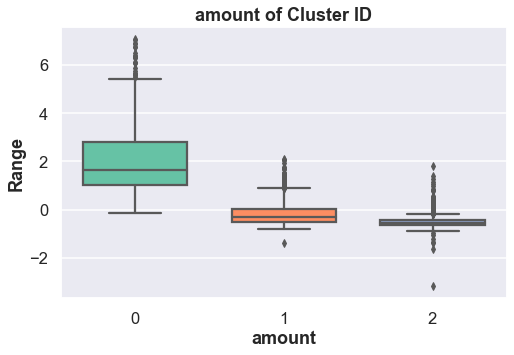

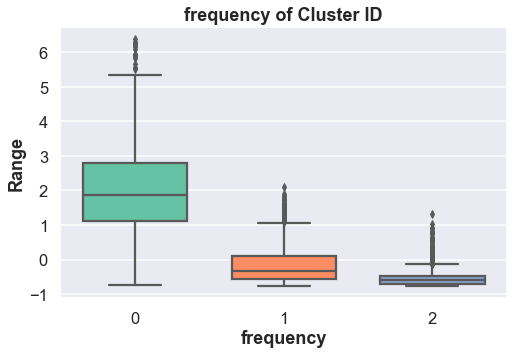

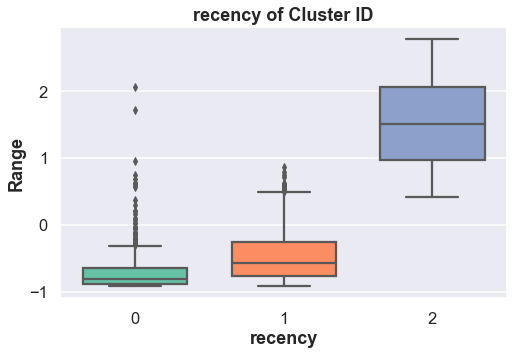

In [266]:
column = ['amount','frequency','recency']

for i,col in enumerate(column):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.figure(i)
    sns.boxplot(x='ClusterID',y=col,data = rfm_df, palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    title = "{} of Cluster ID".format(col)
  
    plt.title(title,fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel(col, fontweight = 'bold')

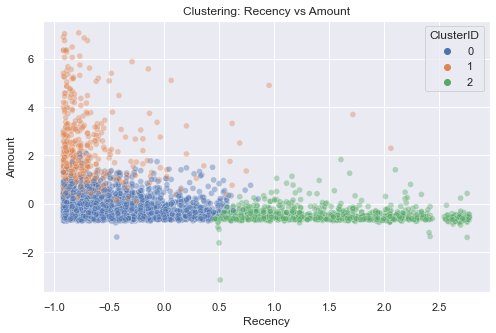

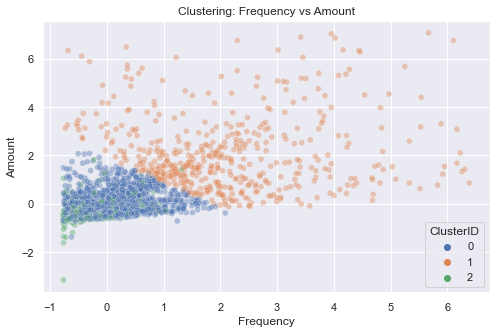

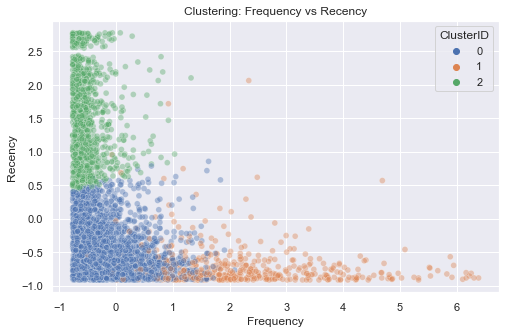

In [409]:
#sns.set_theme('talk')
sns.set_palette("dark")
plt.subplots()
sns.scatterplot(x=rfm_df['recency'], y=rfm_df['amount'], hue=rfm_df['ClusterID'],alpha=0.4,legend="full", palette="deep")
plt.xlabel('Recency')
plt.ylabel('Amount')
plt.title("Clustering: Recency vs Amount")

plt.subplots()
sns.scatterplot(x=rfm_df['frequency'], y=rfm_df['amount'], hue=rfm_df['ClusterID'], alpha=0.4, palette="deep")
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.title("Clustering: Frequency vs Amount")

plt.subplots()
sns.scatterplot(x=rfm_df['frequency'], y=rfm_df['recency'], hue=rfm_df['ClusterID'], alpha=0.4, palette="deep")
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.title("Clustering: Frequency vs Recency");

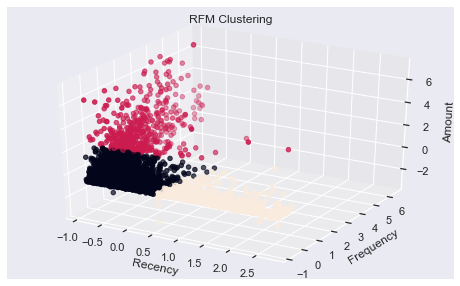

In [410]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=rfm_df['recency'], ys=rfm_df['frequency'], zs=rfm_df['amount'], c=rfm_df['ClusterID'])

plt.title('RFM Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amount');

### Inference 
This 3D scatter graph clearly shows that our K-Means clustering algorithm has successfully segmented all customers into three distinct categories:

Category 1:
Color: blue

number: many

Purchase frequency: mid to high

Amount of spending: high

Recency: high

Category 2:
Color: yellow

Number: many

Purchase frequency: low to mid

Amount of spending: low to mid

Recency: low

Category 3:
Color: green

Number: many

Purchase frequency: low

Amount of spending: low

Recency: high

## Hierarchical Clustering

Now we will deploy Hierarchial Clustering to our data. There are three type of Hierarchical Clustering,

1. Single Linkage: In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. 
2. Complete Linkage :In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. 
3. Average Linkage: In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster

So we will apply all three Hierarchical Clustering and analyses the results.

### Single Linkage:

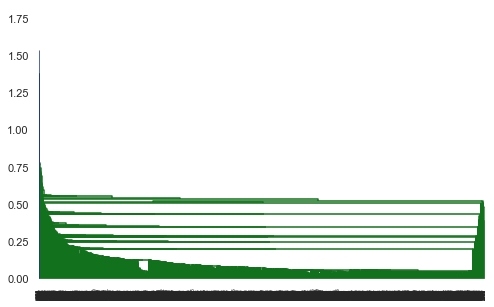

In [412]:
mergings_single = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()


In [413]:
mergings_complete = linkage(rfm_df_scaled, method="complete", metric='euclidean')


### Complete linkage

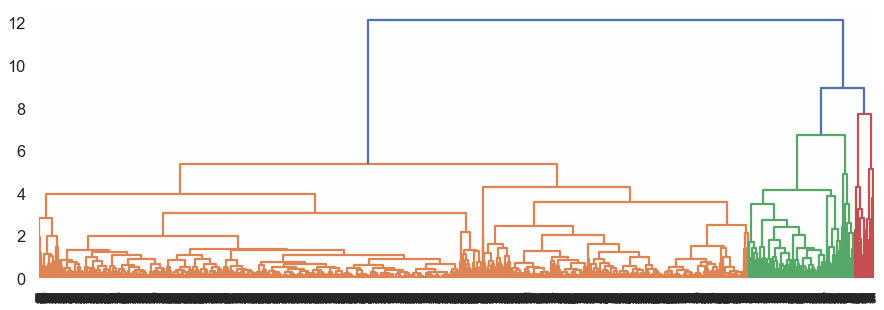

In [194]:
fig, ax = plt.subplots(figsize=(15,5))
den = dendrogram(mergings_complete, orientation='top', 
                           p=30, truncate_mode='level',
                           show_leaf_counts=True, ax=ax
                           )

### Average linkage

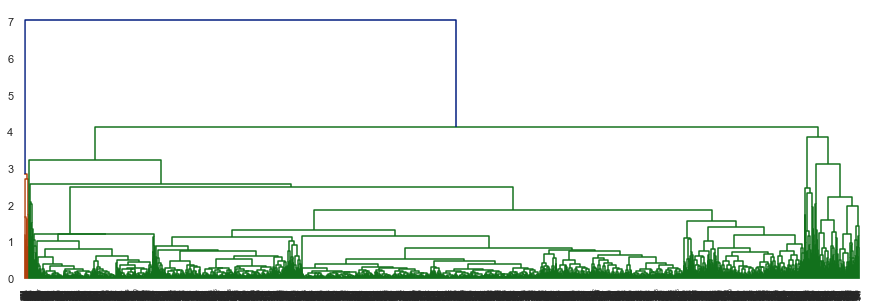

In [414]:
mergings_average = linkage(rfm_df_scaled, method="average", metric='euclidean')

fig, ax = plt.subplots(figsize=(15,5))
den = dendrogram(mergings_average, orientation='top', 
                           p=30, truncate_mode='level',
                           show_leaf_counts=True, ax=ax
                           )

Since the complete linkage shows three cluster dendogram, cut the tree with three clusters and plotted the boxplot and scatter plot for three clusters

In [415]:
cluster_labels = cut_tree(mergings_complete, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [416]:
rfm_df['cluster_labels'] = cluster_labels
rfm_df.head()

,amount,frequency,recency,ClusterID,cluster_labels
0,-0.723738,-0.752888,2.301611,2,0
1,1.731617,1.042467,-0.906466,1,1
2,0.300128,-0.463636,-0.183658,0,0
3,0.277517,-0.044720,-0.738141,0,0
4,-0.533235,-0.603275,2.143188,2,0


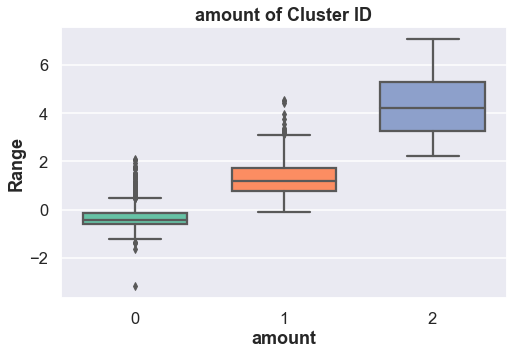

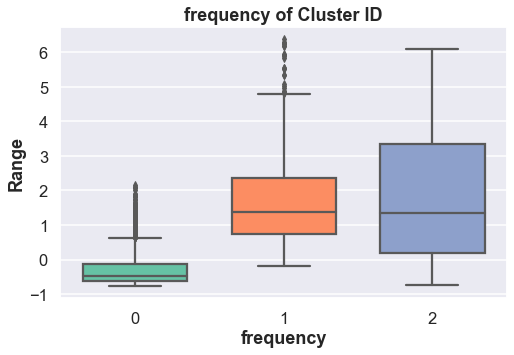

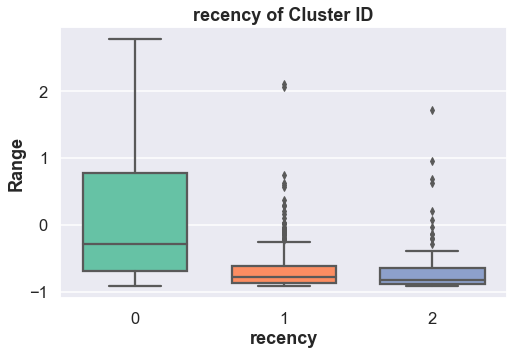

In [281]:
column = ['amount','frequency','recency']

for i,col in enumerate(column):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.figure(i)
    sns.boxplot(x='cluster_labels',y=col,data = rfm_df, palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    title = "{} of Cluster ID".format(col)
  
    plt.title(title,fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel(col, fontweight = 'bold')

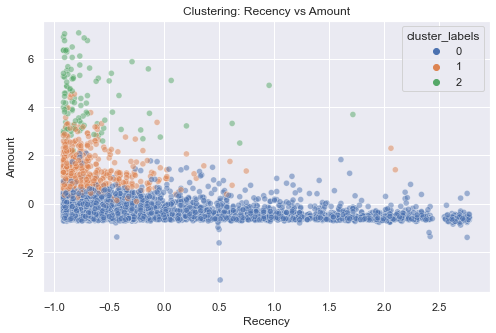

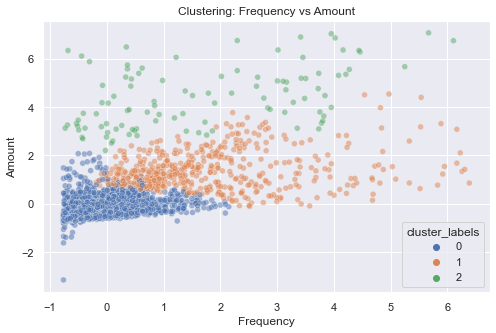

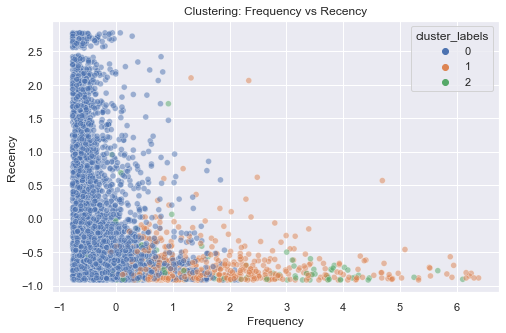

In [417]:
plt.subplots()
sns.scatterplot(x=rfm_df['recency'], y=rfm_df['amount'], hue=rfm_df['cluster_labels'],alpha=0.5,palette="deep")
plt.xlabel('Recency')
plt.ylabel('Amount')
plt.title("Clustering: Recency vs Amount");

plt.subplots()
sns.scatterplot(x=rfm_df['frequency'], y=rfm_df['amount'], hue=rfm_df['cluster_labels'], alpha=0.5,palette="deep")
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.title("Clustering: Frequency vs Amount");

plt.subplots()
sns.scatterplot(x=rfm_df['frequency'], y=rfm_df['recency'], hue=rfm_df['cluster_labels'], alpha=0.5,palette="deep")
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.title("Clustering: Frequency vs Recency");

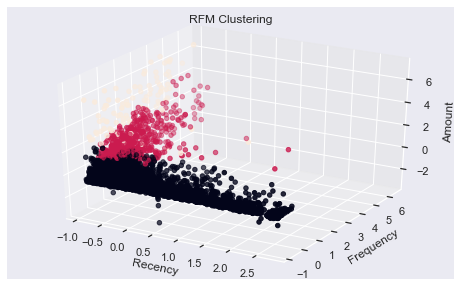

In [418]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=rfm_df['recency'], ys=rfm_df['frequency'], zs=rfm_df['amount'], c=rfm_df['cluster_labels'])

plt.title('RFM Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amount');

## Inference

Scatter plot shows, Hierarchial average cluster divided the customers into three groups, the Recency, Amount and frequency for three groups are:


Category 1:
Color: blue

number: high

Purchase frequency: low 

Amount of spending: low to mid 

Recency: vary

Category 2:
Color: yellow

Number: many

Purchase frequency: low

Amount of spending: low

Recency: low

Category 3:
Color: green

Number: few

Purchase frequency: vary

Amount of spending: high

Recency: low


## DBSCAN Clustering

The concept of DBSCAN is based on the dense regions. The assumption is that natural clusters are composed of densely located points. This requires definition of “dense region”. To do these two parameters are required for DBSCAN algorithm.

Eps, ε - distance
MinPts – Minimum number of points within distance Eps

A “dense region” is therefore created by a minimum number of points within distance between all of them, Eps. Points which are within this distance but not close to minimum number of other points are treated as “border points”. Remaining ones are noise or outliers.

We dont need to define the number of clusters beforehand like, K-means.

Here we apply this model to our data with eps=0.8 and minPts = 7.

In [421]:
db = DBSCAN(eps=0.5, min_samples=10, metric='euclidean')

# fit the model
db.fit(rfm_df_scaled)

DBSCAN(min_samples=10)

In [422]:
db.labels_


array([0, 0, 0, ..., 0, 0, 0])

In [423]:
rfm_df['DBCluster'] = db.labels_

In [424]:
rfm_df.head()

,amount,frequency,recency,ClusterID,cluster_labels,DBCluster
0,-0.723738,-0.752888,2.301611,2,0,0
1,1.731617,1.042467,-0.906466,1,1,0
2,0.300128,-0.463636,-0.183658,0,0,0
3,0.277517,-0.044720,-0.738141,0,0,0
4,-0.533235,-0.603275,2.143188,2,0,0


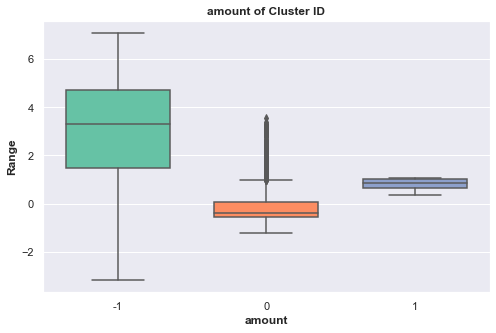

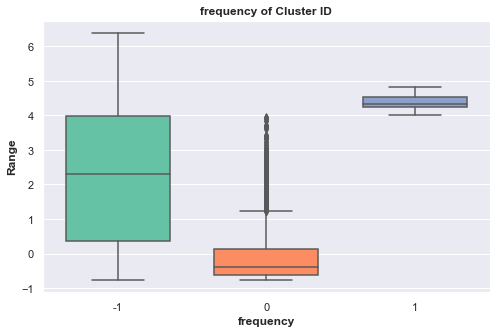

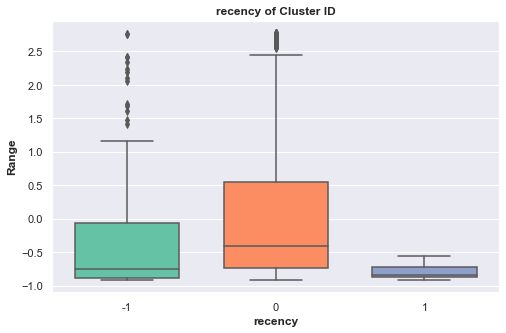

In [425]:
column = ['amount','frequency','recency']

for i,col in enumerate(column):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.figure(i)
    sns.boxplot(x='DBCluster',y=col,data = rfm_df, palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    title = "{} of Cluster ID".format(col)
  
    plt.title(title,fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel(col, fontweight = 'bold')

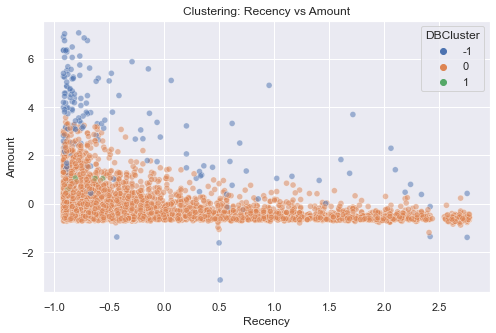

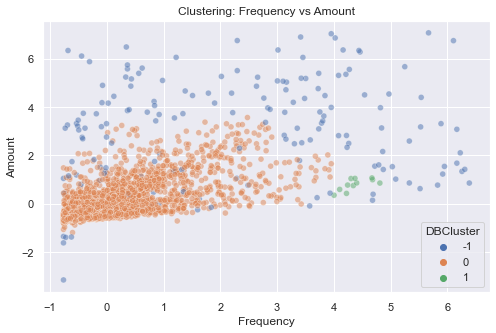

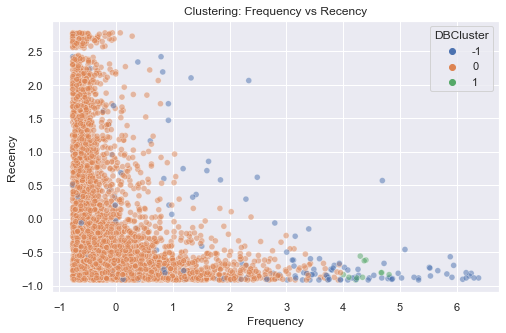

In [426]:
plt.subplots()
sns.scatterplot(x=rfm_df['recency'], y=rfm_df['amount'], hue=rfm_df['DBCluster'],alpha=0.5,palette="deep")
plt.xlabel('Recency')
plt.ylabel('Amount')
plt.title("Clustering: Recency vs Amount")

plt.subplots()
sns.scatterplot(x=rfm_df['frequency'], y=rfm_df['amount'], hue=rfm_df['DBCluster'], alpha=0.5,palette="deep")
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.title("Clustering: Frequency vs Amount")

plt.subplots()
sns.scatterplot(x=rfm_df['frequency'], y=rfm_df['recency'], hue=rfm_df['DBCluster'], alpha=0.5,palette="deep")
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.title("Clustering: Frequency vs Recency");

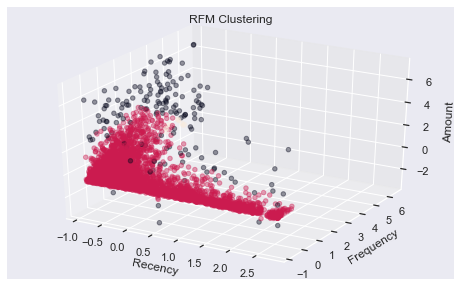

In [427]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=rfm_df['recency'], ys=rfm_df['frequency'], zs=rfm_df['amount'], c=rfm_df['DBCluster'],alpha=0.4)

plt.title('RFM Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amount');

Unlike K means and Hierarchial, he clustering is not optimum for DBSCAN. The clear division of clusters are not visible.

# Analysis

We used K-means, Hierarchial, and DBSCAN to cluster the customer group into three clusters based on the total amount of money spend(M), Frequency(F), and Recency(R). Plotted the scatter plot of different clustering algorithms and it clearly shows that the K-means algorithm, cleanly divided customers into three groups, according to the range of RFM values. The Hierarchical clustering also grouped the customers into three groups, but comparing to the K-means, this method doesn't have an equal proportion for three categories. Cluster number 1 has a majority of customers whether cluster number three has very few. The DBSCAN clustering didn't give a clear output for the segmentation, the cluster formed by this model is very vague, we could not find out a clear division of cluster in this.

# Summary and Future Insights

The goal of this project was to, grouping the customers of an online retail market, according to RFM values. After deploying K means, Hierarchial, and DBSCAN to the data, we found out that, K means clustered the data into three clear clusters. So K-means clustering is the final model with three clusters.

Since DBSCAN is a powerful clustering algorithm, I believe, the wrong Epsilon and MinPoints chosen in this model is the reason for the uncleared clusters created. So as a future step, we could find out the optimum epsilon and minimum points and carry out the clustering with the optimum points. Because of the need for more computational power, I didn't try it.